Introduction

Goal: The aim of this notebook is to build the Machine Learning models that classify whether the proposed salary for a nanny is higher or lower than the assumed threshold.

Content
1. Short Data exploration
2. Cleaning and preparing data for modelling
3. Modelling and evaluation
4. Models explanation
5. Summary and next steps

**1. Short Data exploration**

Since the data I am using has been previously cleaned 
and prepared for analysis and regression modeling, I do not expect that it will require additional cleaning. I am checking the columns, data types, and ensuring that nothing appears concerning.

Download libraries and dataset, adjust display settings:

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import Precision, Recall

plt.style.use('dark_background')
pd.set_option('display.max_columns', None)

nanny = pd.read_csv('dane_klasyfikacja.csv')

In [2]:
nanny.shape

(1424, 30)

In [72]:
nanny.head()

,Unnamed: 0,full_time,part_time,odd,once,non_smoker,has_photo,accepts_animals,experience_twins,cooking,walks,creativity,music,sports,cleaning,laundry,driving_license,author,language1,language2,number_children,city,max_salary_hour,posting_date_regression,ad_source,avg_expected_nannys_age,avg_children_age,avg_expected_experience,girl,boy
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,,Polski,NaN,1,NaN,15,118,m,0.0,2.0,0.0,0,1
1,1,1,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,Mariusz B.,Polski,NaN,1,NaN,15,126,m,0.0,2.0,0.0,0,1
2,2,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,Monika S.,Polski,NaN,1,NaN,30,113,k,0.0,4.5,0.0,0,1
3,3,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,,NaN,NaN,1,NaN,30,126,m,0.0,1.0,0.0,0,1
4,4,0,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,Stefania K.,NaN,NaN,1,NaN,25,122,k,0.0,4.5,2.0,1,0


In [73]:
nanny.dtypes

Unnamed: 0                   int64
full_time                    int64
part_time                    int64
odd                          int64
once                         int64
non_smoker                   int64
has_photo                    int64
accepts_animals              int64
experience_twins             int64
cooking                      int64
walks                        int64
creativity                   int64
music                        int64
sports                       int64
cleaning                     int64
laundry                      int64
driving_license              int64
author                      object
language1                   object
language2                   object
number_children              int64
city                        object
max_salary_hour              int64
posting_date_regression      int64
ad_source                   object
avg_expected_nannys_age    float64
avg_children_age           float64
avg_expected_experience    float64
girl                

In [74]:
nanny.isnull().sum()

Unnamed: 0                    0
full_time                     0
part_time                     0
odd                           0
once                          0
non_smoker                    0
has_photo                     0
accepts_animals               0
experience_twins              0
cooking                       0
walks                         0
creativity                    0
music                         0
sports                        0
cleaning                      0
laundry                       0
driving_license               0
author                       84
language1                   263
language2                  1175
number_children               0
city                        289
max_salary_hour               0
posting_date_regression       0
ad_source                    84
avg_expected_nannys_age       0
avg_children_age              0
avg_expected_experience       0
girl                          0
boy                           0
dtype: int64

In [75]:
nanny.duplicated().sum()

0

In [77]:
nanny.language1.unique()

array(['Polski', nan], dtype=object)

In [76]:
nanny.language2.unique()

array([nan, 'Polski'], dtype=object)

Dataset consists of many columns with 2 main data types such as numerical features (avg_children_age) and categorical data(eg. full_time, part_time, girl, boy). Only language2 column consists mostly of missing values and it does similar information to language1 column so I'll remove it in the next steps. There aren't any duplicated rows in a dataset.

I want to check the distribution in salary column, since it's the most important column in this task.

<AxesSubplot:xlabel='max_salary_hour', ylabel='Count'>

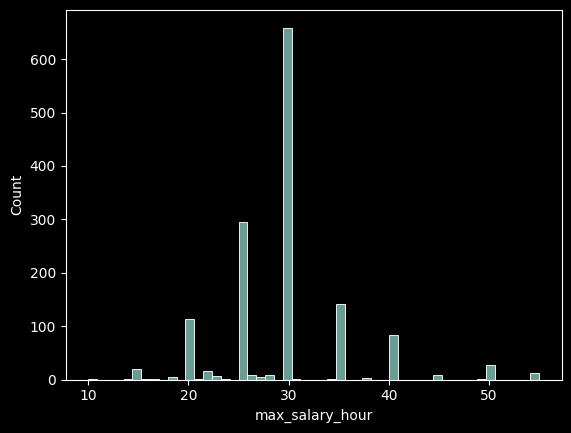

In [7]:
sns.histplot(data = nanny, x="max_salary_hour")

<AxesSubplot:>

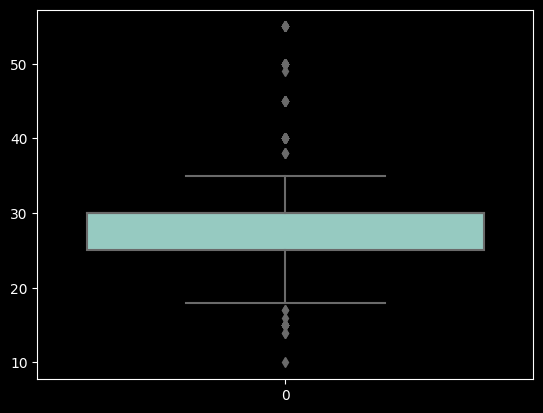

In [8]:
sns.boxplot(nanny['max_salary_hour'])

Distribution is a little bit right-skewed but none of the amount seems to be extremely outstanding.

I'm checking what the average and median rate is for a nannys maximum salary. 

In [9]:
avg_salary = nanny.max_salary_hour.mean()
avg_salary.round(3)

29.525

In [10]:
median = nanny.max_salary_hour.median()
median

30.0

In [11]:
value_counts = nanny['max_salary_hour'].value_counts()

In [12]:
value_counts.head(5)

30    659
25    295
35    141
20    113
40     84
Name: max_salary_hour, dtype: int64

**2. Cleaning and preparing data for modelling**

The values of average and median are similar but the median value occures so many times that it's more accurate to classify it as a low salary.

I want to create a new column that classifies the rate as low or high. Offers below and equal to the median will be classified as low-paid, while offers above it will be classified as well-paid.

- creating new column with classes:

In [13]:
def salary_check(row):
    if row['max_salary_hour'] <= median:
            val = 0 #low salary
    else:
            val = 1 #high salary
        
    return val

In [14]:
nanny['class'] = nanny.apply(salary_check, axis=1)

In [15]:
nanny['class'].unique()

array([0, 1])

- checking if classification is working correcty on random sample:

In [16]:
nanny[['max_salary_hour', 'class']].sample(5)

,max_salary_hour,class
960,40,1
1102,30,0
597,30,0
1196,30,0
381,30,0


Checking the distribution of data:

In [17]:
nanny['class'].value_counts()

0    1143
1     281
Name: class, dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

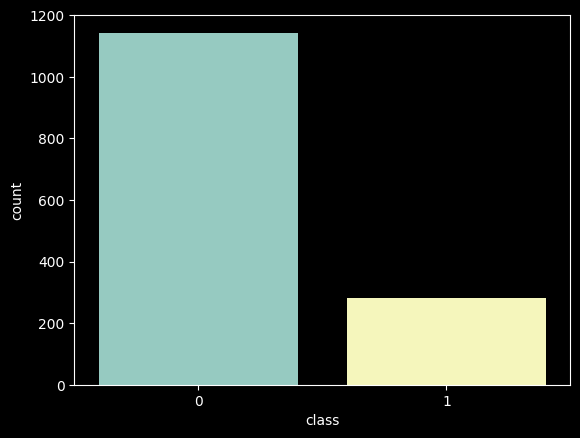

In [18]:
sns.countplot(x = 'class', data = nanny, dodge = True)

We can easily notice a significant disparity between the groups. Since the difference is not extreme(i.e.90% for one class and 10% for the other) metrics don't require adjustment.

 - rounding down the average age of children

In [19]:
for a in nanny['avg_children_age'].index:
    row = nanny['avg_children_age'][a]
    row = int(row)

- deleting unnecessary columns:

In [20]:
nanny = nanny.drop(columns=['Unnamed: 0', 'max_salary_hour', 'language2', 'author'])

- Use One-Hot Encoding for changing categorical data to numerical:

In [22]:
nanny = pd.get_dummies(nanny, columns = ['language1', 'ad_source', 'city'])

In [23]:
nanny.shape

(1424, 53)

The final dataset consists of 55 columns (54 features + target).

In [25]:
null_df = nanny.isnull()
all_null_rows = null_df.all(axis=1)

In [26]:
len(all_null_rows)

1424

- Splitting the dataset into a training set and a test set:

In [28]:
X = nanny.drop(columns=['class'])
y = nanny['class']

- Assign the random state value. Without that every time when the code is executed a new random value is generated and the train and test datasets would have different values each time.

In [29]:
random_state = 21

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = random_state)
print(len(X), len(X_train), len(X_test), len(y_train), len(y_test))

1424 996 428 996 428


In [31]:
type(X_test)

pandas.core.frame.DataFrame

**3. Modelling and evaluation**

I will use tree based model algorithms which doesn't require feature scaling. Those algorithms have many advantages: they're easy to interpret, can capture non-linear relatiionships and are robust to outliers and missing values.

In [32]:
dtc = DecisionTreeClassifier()

In [33]:
rfc = RandomForestClassifier(random_state=random_state)

In [34]:
xgb = XGBClassifier(random_state=random_state)

In [35]:
def checking_algo(algorytm):
    
    algorytm.fit(X_train, y_train)
    
    y_pred_train = algorytm.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    precision_train = precision_score(y_train, y_pred_train, average='macro')
    recall_train = recall_score(y_train, y_pred_train, average='macro')
    f1_train = f1_score(y_train, y_pred_train)
    
    y_pred_test = algorytm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='macro')
    recall = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test)
    
    print(algorytm)
    print("Accuracy train:", accuracy_train.round(3))
    print("Accuracy test:", accuracy.round(3))
    print("Precision train:", recall_train.round(3))
    print("Precision test:", precision.round(3))
    print("Recall train:", recall_train.round(3))
    print("Recall test:", recall.round(3))
    print("F1 train:", f1_train.round(3), '\n')
    print("F1 test:", f1.round(3), '\n')

In [36]:
algo_list = [dtc, rfc, xgb]

I'm checking the results for individual algorithms without setting any parameters:

In [37]:
for a in algo_list:
    checking_algo(a)

DecisionTreeClassifier()
Accuracy train: 1.0
Accuracy test: 0.727
Precision train: 1.0
Precision test: 0.583
Recall train: 1.0
Recall test: 0.593
F1 train: 1.0 

F1 test: 0.346 

RandomForestClassifier(random_state=21)
Accuracy train: 1.0
Accuracy test: 0.827
Precision train: 1.0
Precision test: 0.797
Recall train: 1.0
Recall test: 0.573
F1 train: 1.0 

F1 test: 0.26 

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor

In this case I don't want to foucs neither on true positives rate or on reducing the amount of false negatives. Since the F1 score is the harmonic mean of precision and recall and they're the opposites iI'll be using F1 metric to evalute models performences and see overall evaluation.

Looking at F1 test metric XGB tree model is the best one.
However there is a huge gap between the train and test dataset in all models, they're overfitting - fit too much to the train set and don't generalize well to unseen data. What will be done to improve the performance of the model on the test dataset:
- Perform hyperparameter tuning in a cross-validation to find the best hyperparameters which would tune the model against the F1 score.

Adding parameters to the models from which the function will choose the best ones:

In [40]:
feature_names = X.columns

In [41]:
results = {'model':[], 'precision_train':[], 'precision_test':[], 'recall_train':[], 'recall_test':[], 'f1_train':[], 'f1_test':[], 'auc_train':[], 'auc_test':[] }

In [42]:
params_logreg = dict(
        penalty = ['none', 'l2'],
        solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        C = [1.0, 2.0, 3.0, 4.0, 5.0]
    )

In [43]:
max_depth = list(range(1,10))
n_estimators = list(range(25,250,25))

params_xgb = dict(max_depth=max_depth, n_estimators=n_estimators)

In [44]:
criterion = ['gini', 'entropy']
max_depth = list(range(1,20))
min_samples_split = list(range(1,20))
min_samples_leaf= list(range(1,20))

params_dtc = dict(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf = min_samples_leaf)

In [45]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2] # distance metric parameter that determines the type of distance used to measure 
#the similarity between two data points

params_knn = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [46]:
n_estimators = list(range(40,300,10))
max_depth = list(range(1,20))
min_samples_split = list(range(1,20))
min_samples_leaf = list(range(1,20))

params_rfc = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

I create functions to compare models performence after hpt:
- function that checks all the combinations of parameters above(hpt), chooses the best ones, divides training data on k-folds(many parts) and trains model on them - to improve models performence and decrease overfitting
- functions that shows auc, roc, precision-recall graphs - to visualize models performences
- probability distribution of the positive class (class 1 = high salary) for the training and testing set
- feture importances and shap values - to know each treats were most important and reuse that information in potential feature selection

In [47]:
def best_model(params, model):
    
    hpt = RandomizedSearchCV(model, params, cv=3)
    search = hpt.fit(X_train, y_train)
    print("Best hyperparameters: ", hpt.best_params_)
    model_final = search.best_estimator_
    
    y_test_pred = model_final.predict(X_test)
    y_train_pred = model_final.predict(X_train)
    
    y_test_pred_proba = model_final.predict_proba(X_test) 
    y_train_pred_proba = model_final.predict_proba(X_train)
    
    return {'model': model_final, 'y_test_pred':y_test_pred, 'y_train_pred':y_train_pred,
            'y_test_pred_proba':y_test_pred_proba, 'y_train_pred_proba':y_train_pred_proba}

In [48]:
type(X_test)

pandas.core.frame.DataFrame

In [49]:
def tree_models_scores(model_dec_tree, nazwa):
    model = model_dec_tree['model']
    y_test_pred = model_dec_tree['y_test_pred']
    y_train_pred = model_dec_tree['y_train_pred']
    y_test_pred_proba = model_dec_tree['y_test_pred_proba']
    y_train_pred_proba = model_dec_tree['y_train_pred_proba']
    feature_importances = model.feature_importances_
    
    indices = feature_importances.argsort()[::-1][:5]
    sorted_feature_importances = feature_importances[indices]
    sorted_feature_names = [feature_names[i] for i in indices]
        
    precision_train = precision_score(y_train, y_train_pred, average='macro')
    precision_test = precision_score(y_test, y_test_pred, average='macro')
    recall_train = recall_score(y_train, y_train_pred, average='macro')
    recall_test = recall_score(y_test, y_test_pred, average='macro')
    f1_train = f1_score(y_train, y_train_pred, average = 'binary')
    f1_test = f1_score(y_test, y_test_pred, average = 'binary')
        
    results['model'].append(nazwa)
    results['precision_train'].append(precision_train.round(3))
    results['precision_test'].append(precision_test.round(3))
    results['recall_train'].append(recall_train.round(3))
    results['recall_test'].append(recall_test.round(3))
    results['f1_train'].append(f1_train.round(3))
    results['f1_test'].append(f1_test.round(3))
    
    wynik = {'feature_importances': feature_importances}
    return wynik

In [50]:
type(X_test)

pandas.core.frame.DataFrame

In [51]:
def auc(y, y_pred_proba):    
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:,1])
    auc = metrics.roc_auc_score(y, y_pred_proba[:,1])
    return {'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds, 'auc': auc}

In [52]:
def roc_graph(fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test):
    plt.figure(figsize=(8, 5))
    results['auc_test'].append(auc_test.round(3))
    results['auc_train'].append(auc_train.round(3))
    plt.plot(fpr_train, tpr_train, label="AUC train="+str(auc_train.round(3)))
    plt.plot(fpr_test, tpr_test, label="AUC test="+str(auc_test.round(3)))
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0)
    plt.show()

In [53]:
type(X_test)

pandas.core.frame.DataFrame

In [54]:
def probabilitity_dist(y_train_pred_proba, y_test_pred_proba):
    plt.figure(figsize=(8, 5))
    plt.hist(y_train_pred_proba[:,1], label="Train probability")
    plt.hist(y_test_pred_proba[:,1], label="Test probability")
    plt.title('Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(loc=0)

In [55]:
def precision_recall(y_train_pred_proba, y_test_pred_proba):
    plt.figure(figsize=(8, 5))
    precision, recall, thresholds_train_pr = precision_recall_curve(y_train,y_train_pred_proba[:,1])
    precision_t, recall_t, thresholds_test_pr = precision_recall_curve(y_test,y_test_pred_proba[:,1])
    plt.plot(recall, precision, label='Train Precision-Recall Curve')
    plt.plot(recall_t, precision_t, label='Test Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc=2)

In [56]:
def feature_importances(features):
    
    plt.figure(figsize=(8, 5))
    indices = np.argsort(features)[::-1][:5]
    sorted_feature_importances = features[indices]
    sorted_feature_names = [feature_names[i] for i in indices]
    plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
    plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation='vertical')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')

In [57]:
type(X_test)

pandas.core.frame.DataFrame

In [58]:
def szap(algo):
    plt.figure(figsize=(10, 8))
    vectorizer = TfidfVectorizer()
    explainer = shap.Explainer(algo, X_test, feature_names=X.columns)
    shap_values = explainer(X_test)
    shap.plots.beeswarm(shap_values[:,:,1])

In [59]:
type(X_test)

pandas.core.frame.DataFrame

Combine all the functions in one:

In [60]:
def all_tree(model, params, nazwa):
    
    model_dec_tree = best_model(params, model)
    model = model_dec_tree['model']
    y_test_pred = model_dec_tree['y_test_pred']
    y_train_pred = model_dec_tree['y_train_pred']
    y_test_pred_proba = model_dec_tree['y_test_pred_proba']
    y_train_pred_proba = model_dec_tree['y_train_pred_proba']
    
    drzewo_dec = tree_models_scores(model_dec_tree, nazwa)
    features_tree = drzewo_dec['feature_importances']
    
    auc_tree_train = auc(y_train, y_train_pred_proba)
    fpr_t_train = auc_tree_train['fpr']
    tpr_t_train = auc_tree_train['tpr']
    thresholds_t_train = auc_tree_train['thresholds']
    auc_t_train = auc_tree_train['auc']
    
    auc_tree_test = auc(y_test, y_test_pred_proba)
    fpr_t_test = auc_tree_test['fpr']
    tpr_t_test = auc_tree_test['tpr']
    thresholds_t_test = auc_tree_test['thresholds']
    auc_t_test = auc_tree_test['auc']
    
    roc_graph(fpr_t_train, tpr_t_train, auc_t_train, fpr_t_test, tpr_t_test, auc_t_test)
    probabilitity_dist(y_train_pred_proba, y_test_pred_proba)
    precision_recall(y_train_pred_proba, y_test_pred_proba)
    feature_importances(features_tree)
    szap(model)

In [61]:
algo_drzewa = [dtc, rfc, xgb]
param_drzewa = [params_dtc, params_rfc, params_xgb]
nazwy = ['dec_tree', 'random_f', 'xgb_tree']

In [62]:
type(X_test)

pandas.core.frame.DataFrame

dec_tree
Best hyperparameters:  {'min_samples_split': 4, 'min_samples_leaf': 19, 'max_depth': 4, 'criterion': 'gini'}



3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcin/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcin/.local/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    X_idx_sorted=X_idx_sorted,
  File "/home/marcin/.local/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 254, in fit
    % self.min_samples_split
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

One or more of the test scores are non-fini

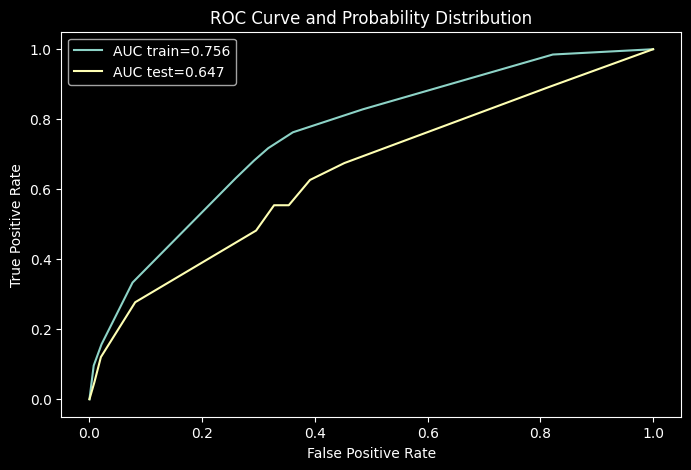

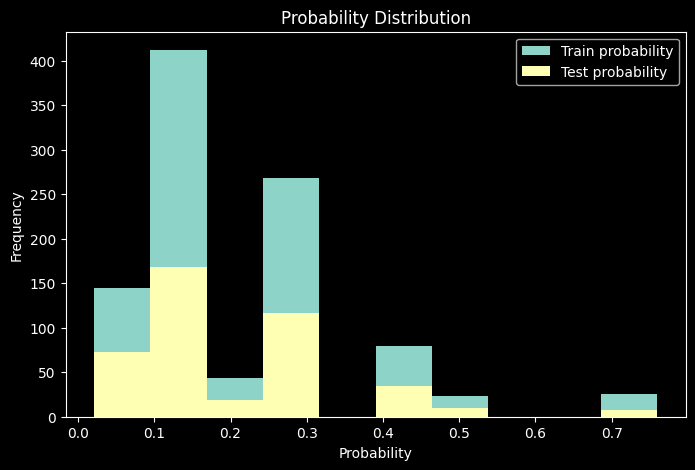

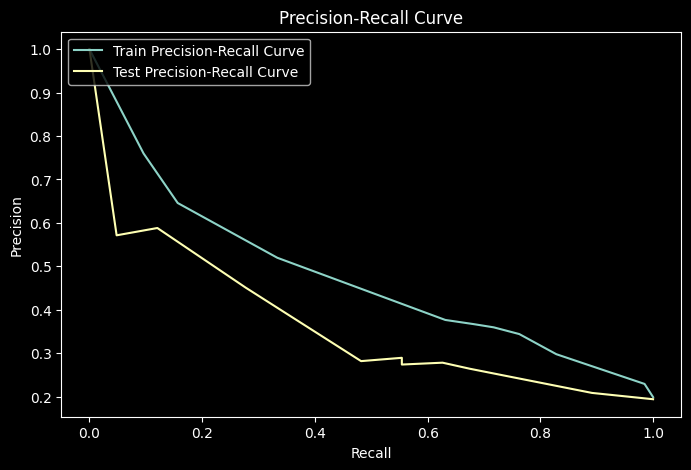

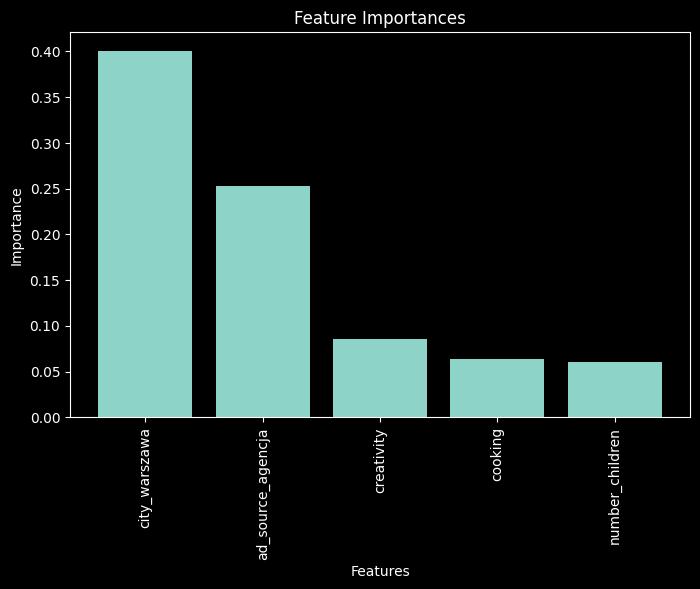

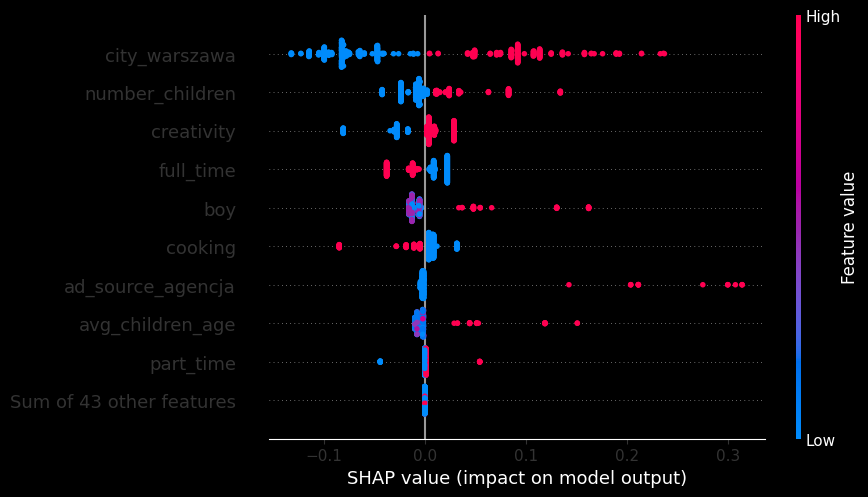

random_f



3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/marcin/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/marcin/.local/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/home/marcin/.local/lib/python3.7/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/home/marcin/.local/lib/python3.7/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)

Best hyperparameters:  {'n_estimators': 140, 'min_samples_split': 11, 'min_samples_leaf': 9, 'max_depth': 19}


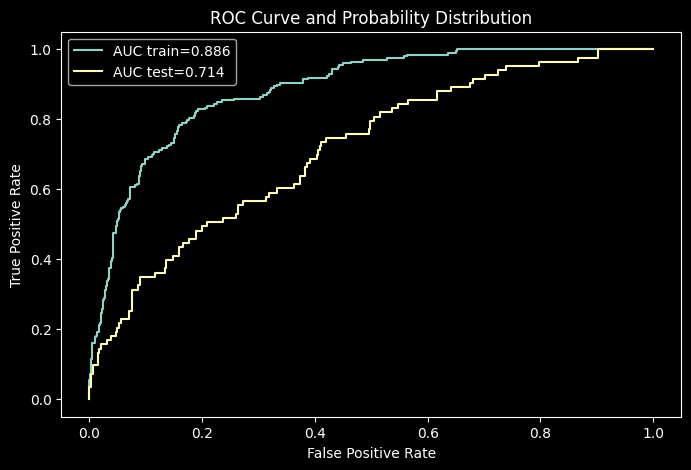

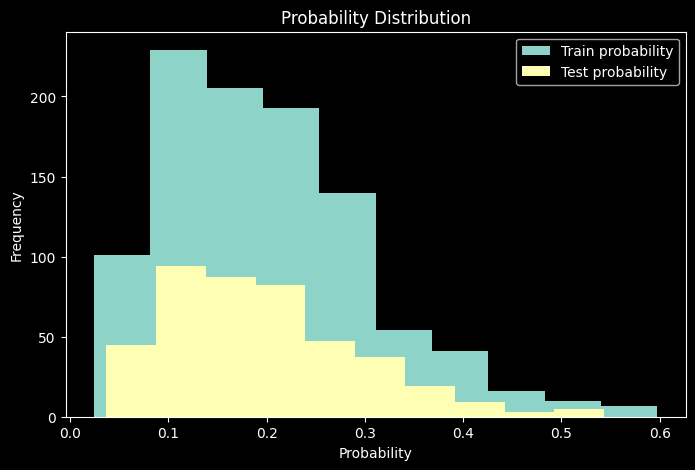

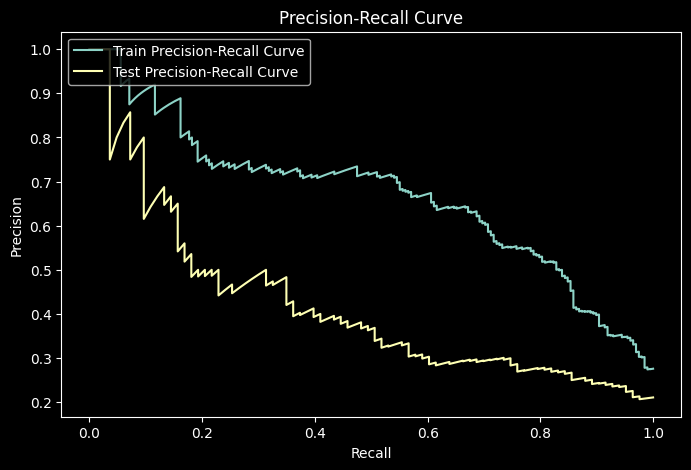

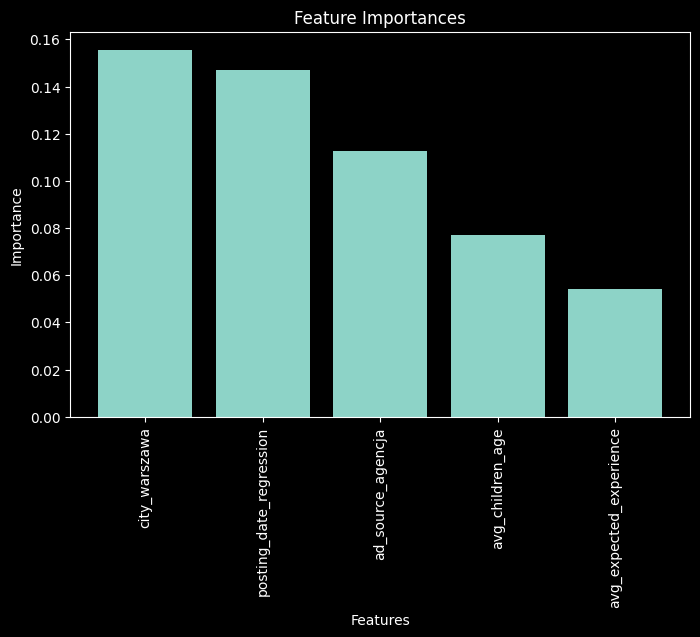

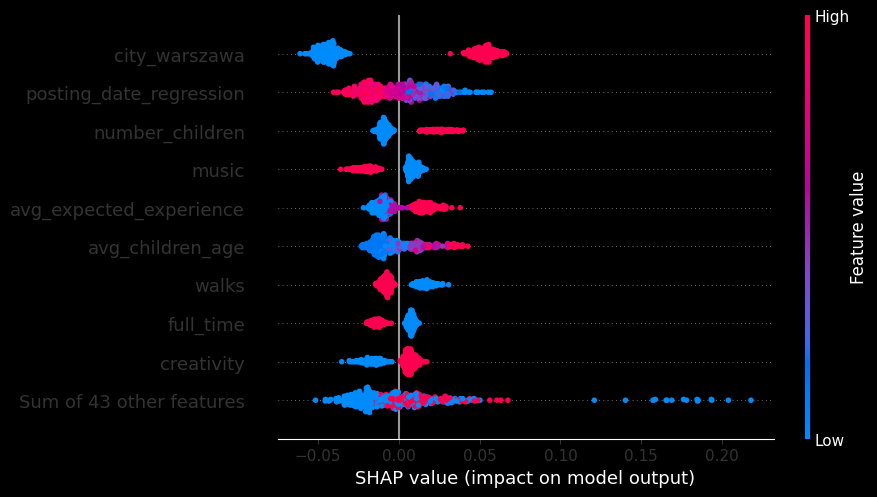

xgb_tree
Best hyperparameters:  {'n_estimators': 100, 'max_depth': 1}


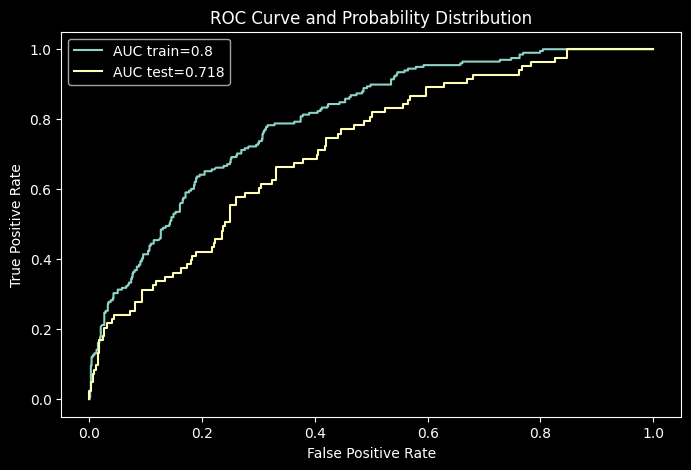

IndexError: too many indices for array

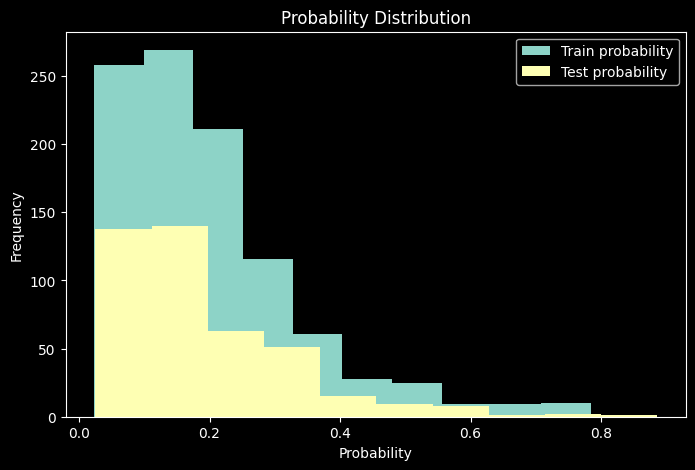

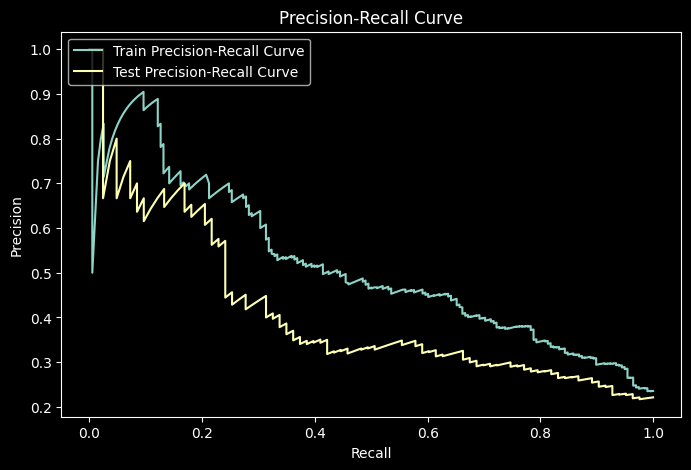

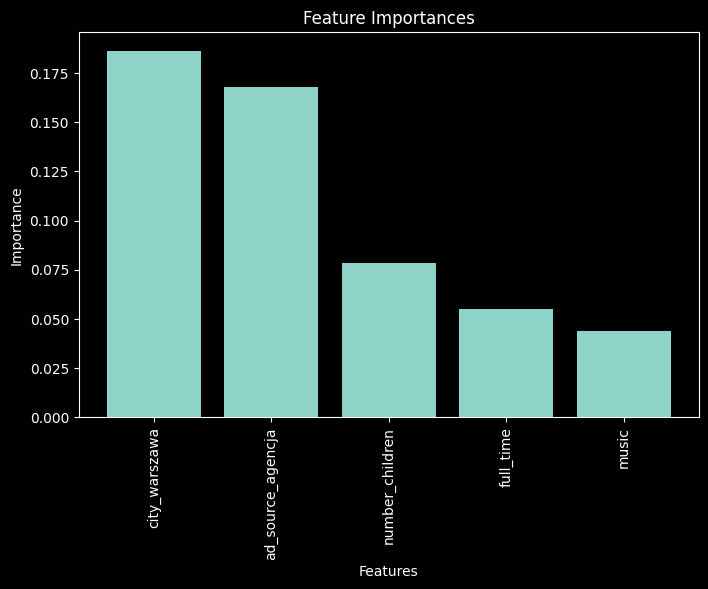

<Figure size 1000x800 with 0 Axes>

In [63]:
for element in range(len(algo_drzewa)):
    print(nazwy[element])
    all_tree(algo_drzewa[element], param_drzewa[element], nazwy[element])


Creating neural network model - they're able to handle complex data, deliver high performance, adapt to various tasks and give the results much better than other algorithms. However it's not easy to adjust their paramaters and it takes a lot of time.

Neural network models require to scale the data so that any feature wouldn't seem more important than the others:

In [65]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = random_state)
print(len(X), len(X_train), len(X_test), len(y_train), len(y_test))

1424 996 428 996 428


- first layer - The input_shape parameter specifies the shape of the input data. In this case, the input shape is (52,) because input data has 52 features. The activity_regularizer parameter applies L1 regularization
 - added next layers with regularizaton and PReLU, Sigmoid activation functions
 - added batch size that determines how many training examples are processed together before updating the model's parameters and number of epochs that specifies the number of times to iterate over the entire training dataset during training

In [67]:
import tensorflow as tf
from tensorflow.keras import regularizers
model = Sequential()
model.add(tf.keras.layers.Dense(256, input_shape = (52,),activity_regularizer=regularizers.l1(10e-5)))
model.add(tf.keras.layers.PReLU(input_shape=(24,))) 
model.add(tf.keras.layers.Dense(16, activity_regularizer=regularizers.l1(10e-5)))
model.add(tf.keras.layers.PReLU(input_shape=(28,)))
model.add(tf.keras.layers.Dense(1, activation="sigmoid", activity_regularizer=regularizers.l1(10e-5)))
model.summary()

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())
model.fit(X_train, y_train, batch_size=128, epochs=20)
model.fit(X_train, y_train, batch_size=32, epochs=80)

y_pred = model.predict(X_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               13568     
                                                                 
 p_re_lu (PReLU)             (None, 256)               256       
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
 p_re_lu_1 (PReLU)           (None, 16)                16        
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 17,969
Trainable params: 17,969
Non-trainable params: 0
_________________________________________________________________


2023-06-21 08:29:22.773643: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-21 08:29:22.774317: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-21 08:29:22.774356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (marcin-Lenovo-Y50-70): /proc/driver/nvidia/version does not exist
2023-06-21 08:29:22.775158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
8/8 [==============================] - 1s 5ms/step - loss: 0.5867
Epoch 2/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4994
Epoch 3/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4853
Epoch 4/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4678
Epoch 5/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4514
Epoch 6/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4410
Epoch 7/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4308
Epoch 8/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4205
Epoch 9/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4129
Epoch 10/20
8/8 [==============================] - 0s 3ms/step - loss: 0.4066
Epoch 11/20
8/8 [==============================] - 0s 3ms/step - loss: 0.3987
Epoch 12/20
8/8 [==============================] - 0s 3ms/step - loss: 0.3944
Epoch 13/20
8/8 [==============================] - 0s 3ms/step - loss: 0.

In [68]:
y_pred_train = model.predict(X_train)
y_pred_labels_train = (y_pred_train > 0.5).astype(int)

accuracy_t = accuracy_score(y_train, y_pred_labels_train)
precision_t = precision_score(y_train, y_pred_labels_train)
recall_t = recall_score(y_train, y_pred_labels_train)
f1_t = f1_score(y_train, y_pred_labels_train)
auc_t = roc_auc_score(y_train, y_pred_labels_train)

y_pred_test = model.predict(X_test)
y_pred_labels_test = (y_pred_test > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_labels_test)
precision = precision_score(y_test, y_pred_labels_test)
recall = recall_score(y_test, y_pred_labels_test)
f1 = f1_score(y_test, y_pred_labels_test)
auc = roc_auc_score(y_test, y_pred_labels_test)

results['model'].append('neural network')
results['precision_train'].append(precision_t.round(3))
results['precision_test'].append(precision.round(3))
results['recall_train'].append(recall_t.round(3))
results['recall_test'].append(recall.round(3))
results['f1_train'].append(f1_t.round(3))
results['f1_test'].append(f1.round(3))
results['auc_train'].append(auc_t.round(3))
results['auc_test'].append(auc.round(3))

14/14 [==============================] - 0s 1ms/step


**4. Models explanation**

Tree based models:
Looking at the ROC curves and precision-recall curves, we can see that the models are still overfitting but the results after hyperparameter tunning are better. Probability of positive class is very low.
The most important features from the models are consistent with the features on the shap graphs. As we can see key attributes are:
- Warsaw city
- job offer posting date
- agency as a job offer source
- number of children

Checking results with neural network algorithm shows that neural network results in F1 metrics are the highest comparing to the tree models ones. Although the model needs adjustment of the parameters. As we can see the gap between train and test results is huge - model is ovefitting.

In [69]:
res = pd.DataFrame(results)
res.sort_values('f1_test', ascending = False)

,model,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test,auc_train,auc_test
3,neural network,1.000,0.308,1.000,0.289,1.000,0.298,1.000,0.566
2,xgb_tree,0.773,0.745,0.571,0.553,0.257,0.204,0.800,0.718
0,dec_tree,0.735,0.705,0.568,0.550,0.252,0.200,0.756,0.647
1,random_f,0.904,0.807,0.523,0.523,0.087,0.091,0.886,0.714


**5. Summary and next steps**

Analysis involved:
- Data inspection and verification. Adjusting the data for ml models by correcting data type, removing unnecessary columns and applying one-hot encoding.
- Modelling predictions using XGBoost Classifier, Decision Tree, Random Forest and Neural Network algorithms which were evaluated against F1 score. The output of the models showed overfitting - additional steps would need to be taken to overcome this issue.
- Graph visualization of ROC, AUC, Precision-Recall curves and probability distribution.
- SHAP analysis showing the contribution of features to the model's decision and comparison with feature importances from the models.


The proposition of next steps:
- Feature Selection: carefully selecting relevant features and removing irrelevant or redundant ones based on result from feature importances and SHAP analysis - it can improve the model's ability to generalize.
- Increase Training Data: having a larger dataset reduces the likelihood of the model memorizing specific examples and improves its ability to generalize.
- Parameters tunning: adjusting the parameters of neural network model 